<font size=6>**Deep Learning - Workshop: Diffusion Models**</font>


<font size=4>IMPORTANT: Don't forget to activate GPU!</font>

# POV: You need to model a distribution!

Let's suppose we are given some [unknown] **empirical distribution**, and we need to generate **mock data**.

<div>
   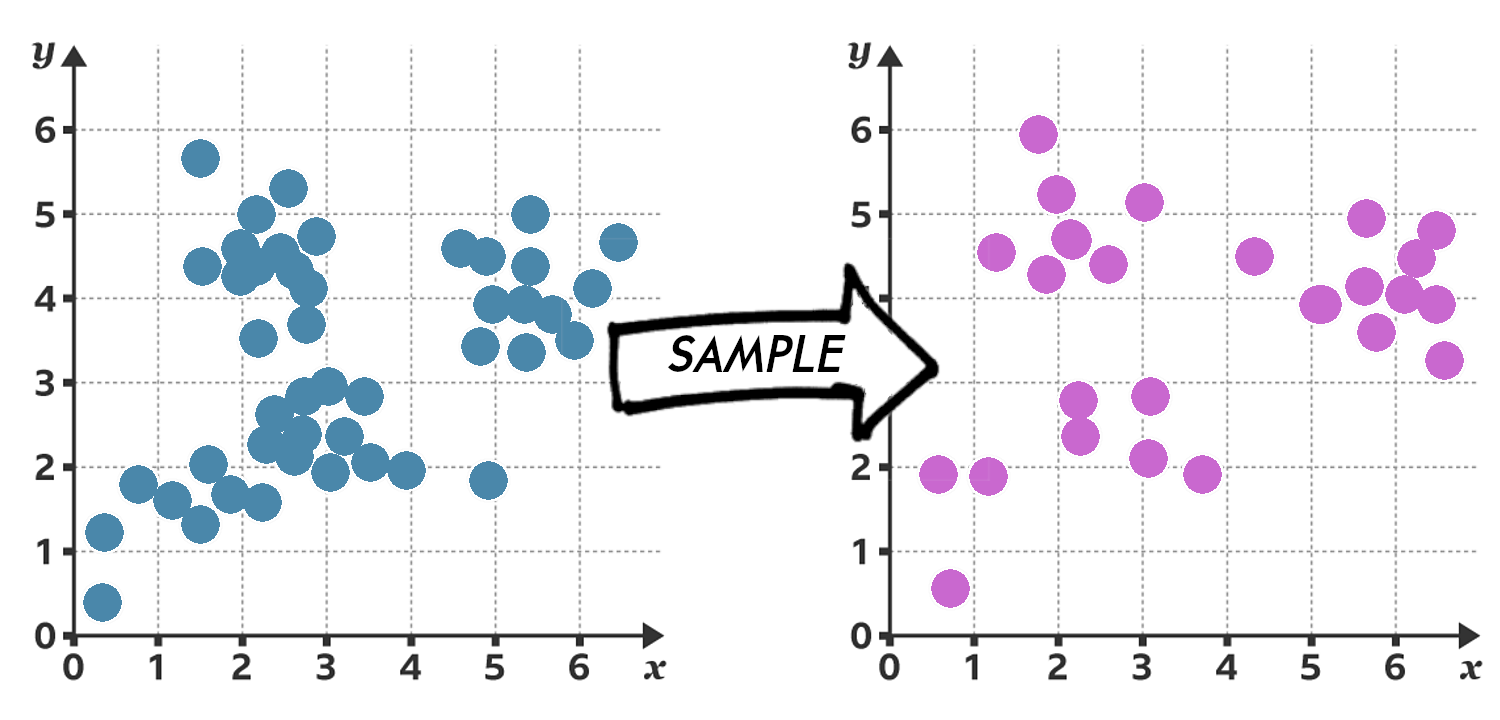
</div>

<table><tr>
    <td width=700>
        <center>
            <br>
            Figure 1.1. The sampling problem.  We need to sample some data (<i>right</i>) based on some empirical distribution (<i>left</i>).<br>
        </center>
    </td>
</tr></table>

<font size=3><u>**Example cases**</u><font>

E.g., you are:

- Running an **expensive simulation** $\rightarrow$ cannot generate _all_ the data analytically

- Dealing with **imbalanced data** $\rightarrow$ need more examples of the minority class

- Assessing **some statistics** $S$ $\rightarrow$ would like to "bootstrap" to obtain a distribution for $S$

<font size=3><u>**In-class discussion**</u><font>

What would you do, if you had to sample _pseudo_-real data given a dataset?
    
_Discuss a few mins with your teammate, then report.  This of possible pros and cons of your method._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
E.g. <b>KDE</b> (<b>Kernel Density Estimation</b>)
<br>
<code>sklearn.neighbors.KernelDensity</code>

We can think of KDE as a **smoothed distribution** (e.g. via Gaussians) of the data.    

<div>
   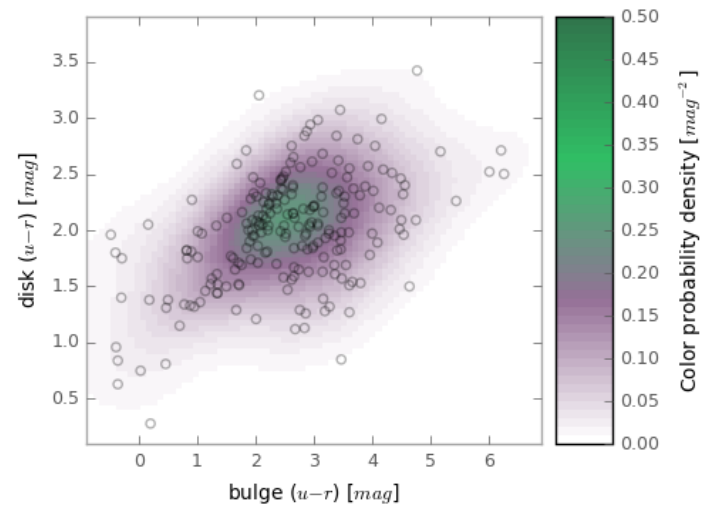
</div>

<table><tr>
    <td width=700>
        <center>
            <br>
            Figure 1b. An example of Kernel Density Estimation applied to a 2D color-color distribution.<br>
            (From <a herf="https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3831B/abstract">Bonfini et al. (2021)</a>)
        </center>
    </td>
</tr></table>

$\rightarrow$ From this **continuous** distribution we can now sample new datasets.
    
<b>PROS</b>:<br>
- Intuitive<br>
- Computationally quick
    
<b>CONS:</b><br>
- Needs parameter tuning (_kernel width_)
- Same global smoothing all over the feature ranges
</details>

- - -
    
In general, a powerful, generalizable model would:
    
- not have **parameters defined ad-hoc** (_parametric models are difficult to define for complex distributions_)
- accounting implicitly for **correlations between features**  
- **adaptable** to the local sub-distribution densities
- **unsupervised**

$\rightarrow$ e.g., **Generative Models**    

## Generative Models $vs$ Discriminative Models

What are **Generative Models**? $\rightarrow$ Best understood when defined in contrast to **Discriminative Models**.

<div>
   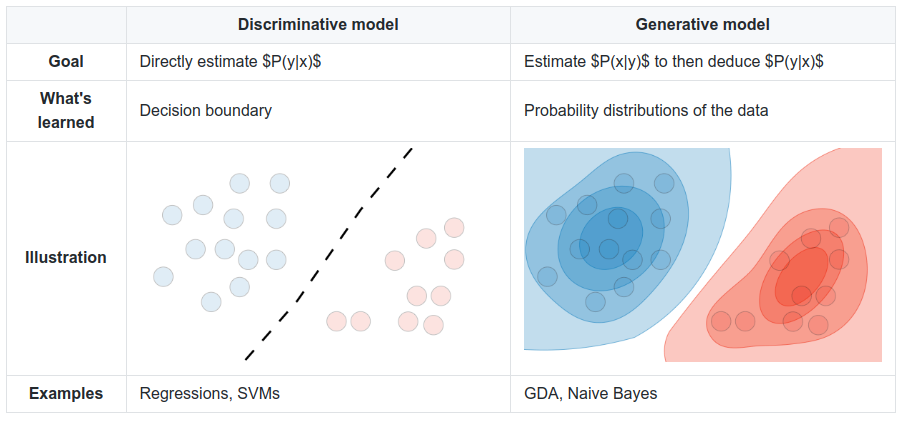
</div>

<table><tr>
    <td width=800>
        <center>
            <br>
            Figure 1.2. Summary comparison of Discriminative (<i>left</i>) $vs$ Generative (<i>right</i>) Models.<br>
            (From <a href=https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning>here</a>)
        </center>
    </td>
</tr></table>

A new paradigm to catalog ML models $\rightarrow$ they can be distinguished based on <u>which probability distribution they target</u>.
 
**Discriminative Models**
- **Objective** $\rightarrow$ Differenciate between sample labels
- **Method** $\rightarrow$ Learn the conditional probability $P(y | X)$

        "How likely is this label?"

**Generative Models**
- **Objective** $\rightarrow$ Create new samples
- **Method** $\rightarrow$ Learn the joint probability $P(X, y)$ $-$ or just $P(X)$ if unsupervised
    
        "How likely is this sample, or this <sample, label> pair?"

See this [Google Developers post](https://developers.google.com/machine-learning/gan/generative) for a smooth intro.

# Diffusion models

- Fancy image generator

- astro: https://github.com/smith42/astroddpm

- Theory from 2D example

# Building a diffusion model

This example has been coded based on [this work](https://medium.com/mlearning-ai/a-toy-diffusion-model-you-can-run-on-your-laptop-20e9e5a83462) by Thiago Lira. 

In [1]:
import torch
import numpy as np
from diffusion import q_sample, posterior_q, Denoising, denoise_with_mu
from utils import pack_data, unpack_1d_data, scatter_pixels

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device in use [cpu/cuda]:', device)

Device in use [cpu/cuda]: cpu


## Importing Data


In [3]:
import os
import wget
import pandas as pd

path_data = './data'
# path of data folder

path_to_data = path_data+"/BPT_emlines.csv"
# path/to/file to be created

# > BPT_emlines.csv
link_data = "https://drive.google.com/uc?id=1wKRU9OKhUcB4Pr3nDYNcNtS2tJpeldek"
#
# Original link: https://drive.google.com/file/d/1wKRU9OKhUcB4Pr3nDYNcNtS2tJpeldek/view?usp=share_link
# - replace: "file/d/" with "uc?id="
# - remove: "/view?usp=share_link"

if not os.path.exists(path_data):
    os.makedirs(path_data)

if not os.path.exists(path_to_data):
    response = wget.download(link_data, path_to_data)

df_data = pd.read_csv(path_to_data)

# Limiting data:
#n_samples = 10000
#df_data = df_data.sample(n=n_samples, random_state=42)
frac_sampling = 0.02
df_data = df_data.groupby('Target_class', group_keys=False).apply(lambda x: x.sample(frac=frac_sampling))
# stratified sampling

display(df_data.head(5))
print(df_data.shape)

,log_sqred_OIII_5007_EQW,D4000_N,log(OIII_5007/H_BETA),log(NII_6584/H_ALPHA),Target_class
30051,2.674522,1.321509,0.697758,-0.013154,AGN
12385,2.089382,1.442062,0.473532,-0.250724,AGN
43352,2.238094,1.765335,0.796639,0.060961,AGN
29500,2.117830,1.445771,0.396778,-0.325202,AGN
38192,1.834786,1.394906,0.300082,-0.068209,AGN


(906, 5)


## Visualizing data

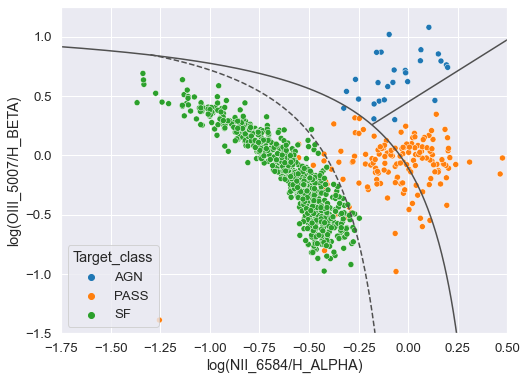

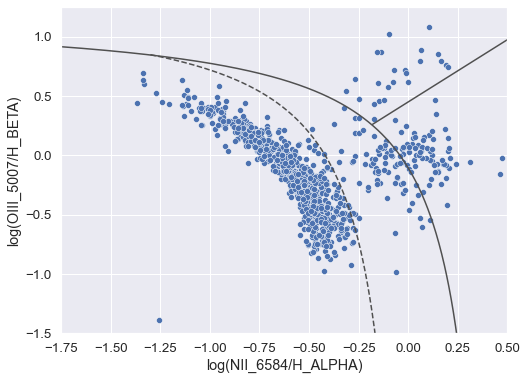

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

# Global Seaborn setup for the reminder of the notebook:
sns.set(font_scale=1.2)

def plot_data(df_data, colored=True):
    plt.figure(figsize=(8, 6))

    if colored:
        ax = sns.scatterplot(data=df_data, x='log(NII_6584/H_ALPHA)', y='log(OIII_5007/H_BETA)',
                    hue='Target_class', palette='tab10')
    else:
        ax = sns.scatterplot(data=df_data, x='log(NII_6584/H_ALPHA)', y='log(OIII_5007/H_BETA)')
            
    # Kewley+01:
    xx_Ke = np.linspace(-2.5, 0.3, 1000)
    yy_Ke = (0.61/( xx_Ke  - 0.47  )) + 1.19

    # Schawinski+07:
    xx_Sc = np.linspace(-0.180, 1.5, 1000)
    yy_Sc = 1.05*xx_Sc + 0.45

    # Kauffmann+03:
    xx_Ka = np.linspace(-1.3, 0., 1000)
    yy_Ka = 0.61/(xx_Ka -0.05) + 1.3

    plt.plot(xx_Ke, yy_Ke, '-' , color='#505050') # Kewley+01
    plt.plot(xx_Sc, yy_Sc, '-',  color='#505050') # Schawinski+07
    plt.plot(xx_Ka, yy_Ka, '--', color='#505050') # Kauffmann+03     
        
    plt.ylim(-1.5,1.25)
    plt.xlim(-1.75,0.5)
    plt.show()
    
plot_data(df_data, colored=True)
plot_data(df_data, colored=False)

## Splitting

_You know the drill ..._

In [5]:
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable

df_X_train, df_X_valid, df_y_train, df_y_valid = \
    train_test_split(df_data[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']],
                     df_data['Target_class'], test_size=0.3, random_state=42)

table = PrettyTable()
table.title = str('Data shape')
table.field_names = ['set', 'X', 'y']
table.add_row(['train',   np.shape(df_X_train), np.shape(df_y_train)])
table.add_row(['valid', np.shape(df_X_valid), np.shape(df_y_valid)])
print(table)

+---------------------------+
|         Data shape        |
+-------+----------+--------+
|  set  |    X     |   y    |
+-------+----------+--------+
| train | (634, 2) | (634,) |
| valid | (272, 2) | (272,) |
+-------+----------+--------+


## Scaling

In [6]:
# Scaling:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_X_train_n = df_X_train.copy()
df_X_valid_n = df_X_valid.copy()

df_X_train_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']] =\
    scaler.fit_transform(df_X_train_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']])

df_X_valid_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']] =\
    scaler.transform(df_X_valid_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']])

In [34]:
# Sending data to device:
one_d_train = pack_data(
    df_X_train_n['log(NII_6584/H_ALPHA)'].values,
    df_X_train_n['log(OIII_5007/H_BETA)'].values
)

X_train = torch.tensor(one_d_train).to(torch.float32).to(device)

DATA_SIZE = len(X_train)

## Diffusion Parameters

In [29]:
beta_start = 0.0004#.0004
beta_end = .06#.02
num_diffusion_timesteps = 25 #250

In [30]:
from operator import mul
from functools import reduce 

betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps) ** 2
alphas = 1 - betas

# send parameters to device
betas = torch.tensor(betas).to(torch.float32).to(device)
alphas = torch.tensor(alphas).to(torch.float32).to(device)

# alpha_bar_t is the product of all alpha_ts from 0 to t
list_bar_alphas = [alphas[0]]
for t in range(1,num_diffusion_timesteps):
    list_bar_alphas.append(reduce(mul,alphas[:t]))
    
list_bar_alphas = torch.cumprod(alphas, axis=0).to(torch.float32).to(device)

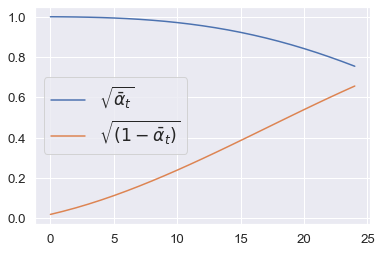

In [31]:
# From here:
#    https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb#scrollTo=oP-rFQUzdx9h
from matplotlib import pyplot as plt

plt.plot(list_bar_alphas ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - list_bar_alphas) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="large");

## Training Procedure

In [32]:
import torch.nn as nn
import torch.optim as optim

training_steps_per_epoch = 2 # 50

criterion = nn.MSELoss()
denoising_model = Denoising(DATA_SIZE, num_diffusion_timesteps).to(device)
# disgusting hack to put embedding layer on 'device' as well, as it is not a pytorch module!
denoising_model.emb = denoising_model.emb.to(device)
optimizer = optim.AdamW(denoising_model.parameters())

### Run training

In [33]:
%%time
from tqdm import tqdm

losses = []
# list of losses, one per epoch

########################################   pbar = tqdm(range(training_steps_per_epoch))
pbar = tqdm(range(50))
for epoch in pbar:  # loop over the dataset multiple times
    
    cum_loss = 0.0
    # sum of losses over the sampled timesteps _within_ an epoch
    
    # sample a bunch of timesteps
    Ts = np.random.randint(1, num_diffusion_timesteps, size=training_steps_per_epoch)
    for _, t in enumerate(Ts):
                
        # produce corrupted sample
        q_t = q_sample(X_train, t, list_bar_alphas, device)
                
        # calculate the mean and variance of the posterior forward distribution q(x_t-1 | x_t,x_0)
        mu_t, cov_t = posterior_q(X_train, q_t, t, alphas, list_bar_alphas, device)
        # get just first element from diagonal of covariance since they are all equal
        sigma_t = cov_t[0][0]
        # zero the parameter gradients
        optimizer.zero_grad()
  
        mu_theta = denoising_model(q_t , t)
        loss = criterion(mu_t, mu_theta)
        loss.backward()
        optimizer.step()
        cum_loss += loss.detach()
    
    losses.append(cum_loss/training_steps_per_epoch)
    # average loss for the current epoch    
    
    pbar.set_description('Epoch: {} Loss: {}'.format(epoch, losses[-1]))
print('Finished Training')

Epoch: 49 Loss: 0.056640803813934326: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]

Finished Training
CPU times: user 27.7 s, sys: 552 ms, total: 28.2 s
Wall time: 7.07 s


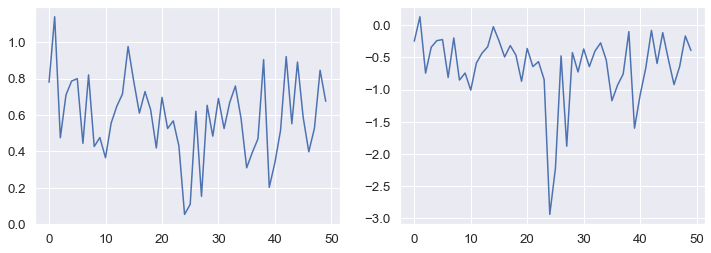

In [28]:
import matplotlib.pyplot as plt

if device != 'cpu':
    losses_ = [loss.detach().cpu().numpy() for loss in losses]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses_)
axs[1].plot(np.log(losses_))
plt.show() 

## Reverse-diffuse to generate one sampled Dataset!

In [14]:
from tqdm import tqdm 
data = torch.distributions.MultivariateNormal(loc=torch.zeros(DATA_SIZE),covariance_matrix=torch.eye(DATA_SIZE)).sample().to(device)

for t in tqdm(range(0,num_diffusion_timesteps)):
    data = denoise_with_mu(denoising_model,data,num_diffusion_timesteps-t-1, alphas, list_bar_alphas, DATA_SIZE, device)

100%|██████████| 50/50 [00:01<00:00, 31.19it/s]


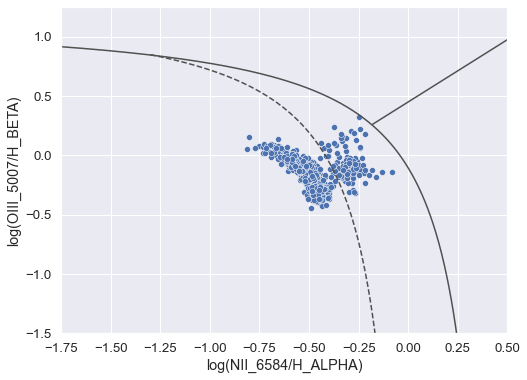

In [15]:
data = data.detach().cpu().numpy()
x_new, y_new = unpack_1d_data(data)

df_data_gen_n = pd.DataFrame(data=np.array([x_new, y_new]).T,
                           columns=['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)'])

df_data_gen = df_data_gen_n.copy()
df_data_gen[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']] =\
    scaler.inverse_transform(df_data_gen[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']])

plot_data(df_data_gen, colored=False)

### Measure K-L

sklearn.metrics.mutual_info_score([0,1],[1,0])

### Create an AWESOME HD 24fps GIF

In [ ]:
data = torch.distributions.MultivariateNormal(loc=torch.zeros(DATA_SIZE),covariance_matrix=torch.eye(DATA_SIZE)).sample().to(device)

In [ ]:
import numpy as np
from celluloid import Camera
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
camera = Camera(fig)

# animation draws one data point at a time
for d in range(1, num_diffusion_timesteps):
    data = denoise_with_mu(denoising_model,data,num_diffusion_timesteps-d, alphas, list_bar_alphas, DATA_SIZE, device)
    data_plot = data.detach().cpu().numpy()
    x_new, y_new = unpack_1d_data(data_plot)
    graph = sns.scatterplot(x=x_new,y=y_new,palette=['green'])
    graph.set_xlim(axes[0])
    graph.set_ylim(axes[1])
    camera.snap()

anim = camera.animate(blit=False)
anim.save('output.gif',fps=24, dpi=120)

In [ ]:
###EOF

In [ ]:
###EOF